In [2]:
import time
import numpy as np
from scipy.io import wavfile

from mir_eval.separation import bss_eval_sources

# We concatenate a few samples to make them long enough
wav_files = [
        ['pyroomacoustics/examples/input_samples/cmu_arctic_us_axb_a0004.wav',
            'pyroomacoustics/examples/input_samples/cmu_arctic_us_axb_a0005.wav',
            'pyroomacoustics/examples/input_samples/cmu_arctic_us_axb_a0006.wav',],
        ['pyroomacoustics/examples/input_samples/cmu_arctic_us_aew_a0001.wav',
            'pyroomacoustics/examples/input_samples/cmu_arctic_us_aew_a0002.wav',
            'pyroomacoustics/examples/input_samples/cmu_arctic_us_aew_a0003.wav',]
        ]

In [3]:


# import argparse
# parser = argparse.ArgumentParser(description='Demonstration of blind source separation using '
#                                                 'IVA, ILRMA, or sparse IVA .')
# parser.add_argument('-b', '--block', type=int, default=2048,
#         help='STFT block size')
# parser.add_argument('-a', '--algo', type=str, default=choices[0], choices=choices,
#         help='Chooses BSS method to run')
# parser.add_argument('--gui', action='store_true',
#         help='Creates a small GUI for easy playback of the sound samples')
# parser.add_argument('--save', action='store_true',
#         help='Saves the output of the separation to wav files')
# args = parser.parse_args()

choices = ['ilrma', 'auxiva', 'sparseauxiva', 'fastmnmf']
block = 2048
algo = choices[0]

In [4]:
import pyroomacoustics as pra
## Prepare one-shot STFT
L = block
hop = L // 2
win_a = pra.hann(L)
win_s = pra.transform.stft.compute_synthesis_window(win_a, hop)

In [5]:
# get signals
# Signal is 2 channels. Channel 0 is 4 + 5 + 6 and channel1 is 1 + 2 + 3
signals = [ np.concatenate([wavfile.read(f)[1].astype(np.float32)
    for f in source_files])
    for source_files in wav_files ]

for source_files in wav_files:
    for f in source_files:
        wave = wavfile.read(f) 
        print(f"file:{f} SampRate:{wave[0]} Duration:{len(wave[1])/wave[0]} s")

file:pyroomacoustics/examples/input_samples/cmu_arctic_us_axb_a0004.wav SampRate:16000 Duration:2.805 s
file:pyroomacoustics/examples/input_samples/cmu_arctic_us_axb_a0005.wav SampRate:16000 Duration:1.5650625 s
file:pyroomacoustics/examples/input_samples/cmu_arctic_us_axb_a0006.wav SampRate:16000 Duration:3.54 s
file:pyroomacoustics/examples/input_samples/cmu_arctic_us_aew_a0001.wav SampRate:16000 Duration:3.8800625 s
file:pyroomacoustics/examples/input_samples/cmu_arctic_us_aew_a0002.wav SampRate:16000 Duration:4.0200625 s
file:pyroomacoustics/examples/input_samples/cmu_arctic_us_aew_a0003.wav SampRate:16000 Duration:3.5400625 s


[-21. -21. -28. ... 129. 110. 100.] 1.0 [2.5, 3]
[29. 34. 38. ... 53. 54. 52.] 0.0 [2.5, 6]


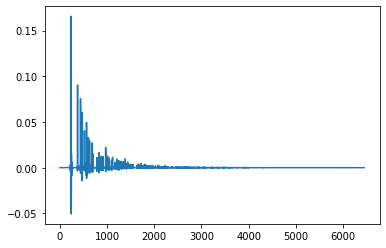

In [6]:
## Create a room with sources and mics
# Room dimensions in meters
room_dim = [8, 9]

# source location
source = np.array([1, 4.5])
room = pra.ShoeBox(
    room_dim,
    fs=16000,
    max_order=15,
    absorption=0.35,
    sigma2_awgn=1e-8)

# add mic and good source to room
# add silent signals to all sources
delays = [1., 0.]
locations = [[2.5,3], [2.5, 6]]
for sig, d, loc in zip(signals, delays, locations):
    print(sig,d,loc)
    room.add_source(loc, signal=np.zeros_like(sig), delay=d)

# add microphone array
room.add_microphone_array(
        pra.MicrophoneArray(np.c_[[6.5, 4.49], [6.5, 4.51]], fs=room.fs)
        )

# compute RIRs
room.compute_rir()
import matplotlib.pyplot as plt
plt.plot(room.rir[1][0])
plt.show()

In [7]:
# Record each source separately
separate_recordings = []
for source, signal in zip(room.sources, signals):
    # print(source, signal)
    source.signal[:] = signal

    room.simulate()
    separate_recordings.append(room.mic_array.signals)
    print(room.mic_array.signals)
    print(room.mic_array.signals.shape)
    print()
    source.signal[:] = 0.

separate_recordings = np.array(separate_recordings)
# Mix down the recorded signals
mics_signals = np.sum(separate_recordings, axis=0)
# print(separate_recordings.shape) #(2, 2, 189494)
# print(np.moveaxis(separate_recordings, 1, 2).shape) #(2, 189494, 2)
ref = np.moveaxis(separate_recordings, 1, 2)

[[-1.72427564e-04 -3.12425490e-05 -5.48519508e-05 ... -3.28032248e-06
   9.23797432e-05  1.35136769e-05]
 [-4.60692379e-06 -1.16154795e-04  1.24327826e-04 ... -8.56630908e-06
  -1.57370725e-04  1.91425269e-04]]
(2, 189494)

[[-7.09378215e-05 -1.62915504e-04 -1.30445904e-04 ...  2.18639207e-06
   2.62257365e-05 -6.98736220e-06]
 [ 1.81479755e-04 -1.83146022e-04 -1.92149864e-05 ... -1.76575247e-04
  -2.14855906e-04  1.03031669e-05]]
(2, 189494)



In [8]:
def convergence_callback(Y):
    global SDR, SIR
    from mir_eval.separation import bss_eval_sources
    ref = np.moveaxis(separate_recordings, 1, 2)
    y = pra.transform.stft.synthesis(Y, L, hop, win=win_s)
    y = y[L-hop: , :].T
    m = np.minimum(y.shape[1], ref.shape[1])
    sdr, sir, sar, perm = bss_eval_sources(ref[:, :m, 0], y[:, :m])
    SDR.append(sdr)
    SIR.append(sir)
    # print(sdr, sir, sar, perm)

In [37]:
SDR, SIR = [], []
## STFT ANALYSIS
X = pra.transform.stft.analysis(mics_signals.T, L, hop, win=win_a)

t_begin = time.perf_counter()


## START BSS
bss_type = 'ilrma'
if bss_type == 'auxiva':
    # Run AuxIVA
    Y = pra.bss.auxiva(X, n_iter=30, proj_back=True,
                        callback=convergence_callback)
elif bss_type == 'ilrma':
    # Run ILRMA
    Y = pra.bss.ilrma(X, n_iter=100, n_components=3, proj_back=True,
                        callback=convergence_callback)
elif bss_type == 'fastmnmf':
    # Run FastMNMF
    Y = pra.bss.fastmnmf(X, n_iter=30, n_components=8, n_src=2,
                        callback=convergence_callback)
elif bss_type == 'sparseauxiva':
    # Estimate set of active frequency bins
    ratio = 0.35
    average = np.abs(np.mean(np.mean(X, axis=2), axis=0))
    k = np.int_(average.shape[0] * ratio)
    S = np.sort(np.argpartition(average, -k)[-k:])
    # Run SparseAuxIva
    Y = pra.bss.sparseauxiva(X, S, n_iter=30, proj_back=True,
                                callback=convergence_callback)

t_end = time.perf_counter()
print("Time for BSS: {:.2f} s".format(t_end - t_begin))

## STFT Synthesis
y = pra.transform.stft.synthesis(Y, L, hop, win=win_s)
print(y.shape)
## Compare SDR and SIR
y = y[L-hop:, :].T
m = np.minimum(y.shape[1], ref.shape[1])
sdr, sir, sar, perm = bss_eval_sources(ref[:, :m, 0], y[:, :m])
print('SDR:', sdr)
print('SIR:', sir)

Time for BSS: 12.30 s
(190464, 2)
SDR: [ 9.84745964 10.51851054]
SIR: [15.10963302 16.01933268]


In [9]:
# Save OUTPUT
from scipy.io import wavfile

wavfile.write('audio/bss_ilrma_mix.wav', room.fs,
        pra.normalize(mics_signals.T, bits=16).astype(np.int16))
for i, sig in enumerate(y):
    wavfile.write(f'audio/bss_ilrma_source{i+1}.wav', room.fs,
            pra.normalize(sig, bits=16).astype(np.int16))

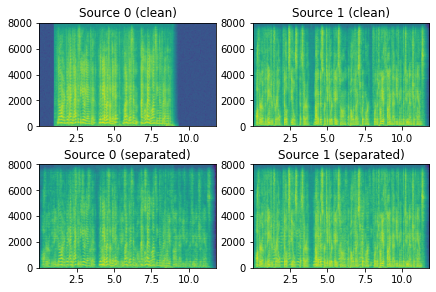

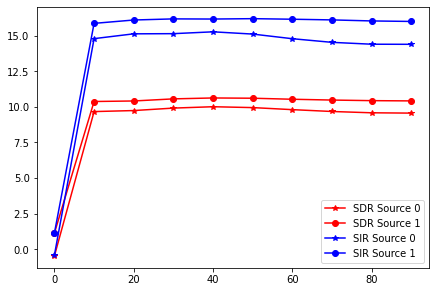

In [10]:
## PLOT RESULTS
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(2,2,1)
plt.specgram(ref[0,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (clean)')

plt.subplot(2,2,2)
plt.specgram(ref[1,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (clean)')

plt.subplot(2,2,3)
plt.specgram(y[perm[0],:], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (separated)')

plt.subplot(2,2,4)
plt.specgram(y[perm[1],:], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (separated)')

plt.tight_layout(pad=0.5)

plt.figure()
a = np.array(SDR)
b = np.array(SIR)
plt.plot(np.arange(a.shape[0]) * 10, a[:,0], label='SDR Source 0', c='r', marker='*')
plt.plot(np.arange(a.shape[0]) * 10, a[:,1], label='SDR Source 1', c='r', marker='o')
plt.plot(np.arange(b.shape[0]) * 10, b[:,0], label='SIR Source 0', c='b', marker='*')
plt.plot(np.arange(b.shape[0]) * 10, b[:,1], label='SIR Source 1', c='b', marker='o')
plt.legend()

plt.tight_layout(pad=0.5)

In [18]:
print(separate_recordings.shape) #(2, 2, 189494)
# It is 2 stereo tracks. (track, L/R, Time)
track1 = separate_recordings[0,:,:]
track2 = separate_recordings[1,:,:]
# track1.shape #(2, 189494)

# Make sure I extracted the correct track information
# wavfile.write(f'audio/track1.wav', room.fs,
#     pra.normalize(track1.T, bits=16).astype(np.int16))
# wavfile.write(f'audio/track2.wav', room.fs,
#     pra.normalize(track2.T, bits=16).astype(np.int16))

(2, 2, 189494)


In [32]:
from sklearn.decomposition import FastICA
# Use all default parameter of FastICA
fica = FastICA()
# X = (n_samples, n_features)
# print(mics_signals.shape)
unmixed_audio = fica.fit_transform(mics_signals.T).T

In [33]:
# mix_audio = mics_signals[0,:].reshape(1,-1)
# print(mix_audio.shape) #(1, 189494)

# unmixed_audio = y
print(unmixed_audio.shape) #(2, 189440)

(2, 189494)


In [20]:
from scipy.io import wavfile
for i, sig in enumerate(unmixed_audio):
    wavfile.write(f'audio/bss_FastICA_source{i+1}.wav', room.fs,
            pra.normalize(sig, bits=16).astype(np.int16))

In [36]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from sklearn.cross_decomposition import CCA
def cal_correlation_coefficient(corr,mode='max',abs=False):
    import numpy as np
    _list_mode = ['max','sum']
    if(type(corr) != type(np.array([]))): corr = np.array(corr)
    if(mode not in _list_mode): raise ValueError(f"mode can only be {_list_mode}")
    if(abs): corr = np.abs(corr)
    if(mode == 'max'): return corr.max(axis=1)
    if(mode == 'sum'): return corr.sum(axis=1)

corr_mode = 'sum'
corr_abs = True

# Evaluate
original = np.concatenate([track1,track2], axis=0)
# original.shape #(4, 189494)

R = np.corrcoef(unmixed_audio, original)
corr = cal_correlation_coefficient(R[:2,2:2+4],mode=corr_mode,abs=corr_abs)
print(corr.shape) #(2,)
print(corr) #(2,)
# Step4
# argsort is acsding. [::-1] will revert the result
group = []
EVs = []
for idx in tqdm(corr.argsort()[::-1],desc='EVs'):
    group.append(idx)
    # print(transformed_eeg.T[group].shape)
    # For each subset of EEG components, applied CCA
    ev_cca = CCA(n_components=len(group))
    ev_cca.fit(unmixed_audio[group].T,original.T)
    ev_R = np.corrcoef(ev_cca.x_scores_.T,ev_cca.y_scores_.T)
    # print(ev_R.shape)
    # print(ev_R)
    # the "sum of canonical correlation coefficients" was calculated for each freq, state, and subject
    ccc = cal_correlation_coefficient(ev_R[:len(group),len(group):2*len(group)],mode='sum',abs=True)
    EVs.append(ccc)
    # print(EVs)
    # if(len(group) == 16): break
print("EVs", EVs)


## Compare SDR and SIR
L = 2048
hop = 2048//2

# unmixed_audio = unmixed_audio[:, L-hop:]
m = np.minimum(unmixed_audio.shape[1], ref.shape[1])
sdr, sir, sar, perm = bss_eval_sources(ref[:, :m, 0], unmixed_audio[:, :m])
print(sdr, sir, sar, perm)
# scipy.io.savemat(f'BSS/CCA_{state}{component}.mat', dict({'EVs': EVs}))

(2,)
[2.85855311 0.26380103]



EVs [array([1.]), array([1., 1.])]
[-0.47919335  0.6839866 ] [-0.46332151  4.65766564] [27.1484455   4.18434594] [0 1]


ILRMA

In [13]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from sklearn.cross_decomposition import CCA
def cal_correlation_coefficient(corr,mode='max',abs=False):
    import numpy as np
    _list_mode = ['max','sum']
    if(type(corr) != type(np.array([]))): corr = np.array(corr)
    if(mode not in _list_mode): raise ValueError(f"mode can only be {_list_mode}")
    if(abs): corr = np.abs(corr)
    if(mode == 'max'): return corr.max(axis=1)
    if(mode == 'sum'): return corr.sum(axis=1)

corr_mode = 'sum'
corr_abs = True

# Evaluate
original = np.concatenate([track1,track2], axis=0)
# original.shape #(4, 189494)

R = np.corrcoef(unmixed_audio, original[:,:189440])
corr = cal_correlation_coefficient(R[:2,2:2+4],mode=corr_mode,abs=corr_abs)
print(corr.shape) #(2,)
print(corr) #(2,)
# Step4
# argsort is acsding. [::-1] will revert the result
group = []
EVs = []
for idx in tqdm(corr.argsort()[::-1],desc='EVs'):
    group.append(idx)
    # print(transformed_eeg.T[group].shape)
    # For each subset of EEG components, applied CCA
    ev_cca = CCA(n_components=len(group))
    ev_cca.fit(unmixed_audio[group].T,original[:,:189440].T)
    ev_R = np.corrcoef(ev_cca.x_scores_.T,ev_cca.y_scores_.T)
    # print(ev_R.shape)
    # print(ev_R)
    # the "sum of canonical correlation coefficients" was calculated for each freq, state, and subject
    ccc = cal_correlation_coefficient(ev_R[:len(group),len(group):2*len(group)],mode='sum',abs=True)
    EVs.append(ccc)
    # print(EVs)
    # if(len(group) == 16): break
print(EVs)
# scipy.io.savemat(f'BSS/CCA_{state}{component}.mat', dict({'EVs': EVs}))

(2,)
[2.17462708 2.08060534]



[array([0.94940518]), array([0.99346635, 0.89417889])]
